<a href="https://colab.research.google.com/github/diegohdz02/Notas-SDNL/blob/main/MotivatingPrivacy_MarioDiaz_FC230223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Fairness-Aware Classification Problem: Finding and Destroying Correlations

<br>

<br>

<br>

<br>

<br>

<br>

<br>

Mario Diaz, IIMAS-UNAM<br>
mario.diaz@sigma.iimas.unam.mx<br>
https://mariodiaztorres.com/

<br>

<br>

<br>

<br>

<br>

<br>

March 2023

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<b>Problem.</b> Given a portion of the 1994 US census dataset,<br>
> design a <font color="blue"><i>classifier</i></font> that predicts the income bracket of an individual based on a certain set of attributes.

<br>

<br>

<br>

<br>

<b>Proposed Solution.</b> A modified version of the ordinary least squares estimator, aka<br>
> a <font color="blue"><i>1-layer neural network</i></font> with sign activation fuction.

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

## Loading Libraries & UCI Adult Census Income Dataset

Numpy, pandas, matplotlib & scikit-learn.

In [ ]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

Census data containing demographic features of adults and their income.

In [ ]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

As usual, one part of the dataset is used for <font color="blue"><i>training</i></font> (30162 samples) and another one for <font color="blue"><i>testing</i></font> (15060 samples).

In [ ]:
train_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=COLUMNS,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")
test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=COLUMNS,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?")

# Drop rows with missing values
train_df = train_df.dropna(how="any", axis=0)
test_df = test_df.dropna(how="any", axis=0)

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

## Preprocessing

We want to predict <font color="blue"><i>income bracket</i></font> using: <font color="blue"><i>age</i></font>, <font color="blue"><i>education</i></font>, <font color="blue"><i>occupation</i></font> and <font color="blue"><i>gender</i></font>.

In [ ]:
X = train_df.values[:,[0,3,6,9]]
Y = train_df.values[:,14]

### Age

The <font color="blue"><i>age</i></font> feature ranges between 17 and 90. In order to normalize it, we apply the transformation

$$ x \mapsto \frac{x-17}{90 - 17}.$$

In [ ]:
X[:,0] = (X[:,0] - 17.0)/73.0

### Education

The <font color="blue"><i>education</i></font> feature takes 16 different values. To each value, we assign a number of the form $\displaystyle \frac{k}{15}$.

In [ ]:
enc_edu = MyLabelEncoder()
enc_edu.fit(["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th",
                    "12th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc",
                    "Some-college", "Bachelors", "Masters", "Doctorate"])
X[:,1] = enc_edu.transform(X[:,1])/15.0

### Occupation

There are 14 different <font color="blue"><i>occupations</i></font>, each of those is treated as a binary attribute. Namely, $x_{\text{occ}_{i}} = 1$ if a given individual works in $\text{occupation}_{i}$ and $x_{\text{occ}_{i}} = 0$ otherwise, e.g.,

$$ (1,0,0,\ldots,0,0) \quad \text{or} \quad (0,1,0,\ldots,0,0) \quad \text{or} \quad (0,0,0,\ldots,0,1).$$

In [ ]:
ohe = OneHotEncoder()
X_occ = ohe.fit_transform(X[:,[2]]).toarray()

### Gender

The <font color="blue"><i>gender</i></font> attribute is set to 1 if a given individual is female and 0 otherwise.

In [ ]:
enc_gen = MyLabelEncoder()
enc_gen.fit(["Male","Female"])
X[:,3] = enc_gen.transform(X[:,3])

We put all these features together in a matrix called <i>X_train</i>.

<br>

> Each row of <i>X_train</i> has 2 real variables (age & education) and 14 binary variables (13 occupations & gender).
> $$ x = (x_{\text{age}}, x_{\text{education}}, x_{\text{occ}_{1}}, \ldots, x_{\text{occ}_{13}}, x_{\text{gender}}). $$

In [ ]:
X_train = np.concatenate((X[:,[0,1]],X_occ[:,range(1,14)],X[:,[3]]), axis=1)

### Income Bracket

<font color="blue"><i>Income bracket</i></font> takes two values: "<=50K" and ">50K". We encode this attribute in a variable called <i>Y_train</i>.

<br>

> This attribute is represented by a binary variable, say $y$.

<br>

<b>Note.</b> This is the variable to be predicted using the previous ones, i.e.,
> we want to find a <font color="blue"><i>classifier</i></font> $h:\mathbb{R}^{16}\to\{0,1\}$ such that $y \approx h(x)$.

In [ ]:
enc_inc = MyLabelEncoder()
enc_inc.fit(["<=50K", ">50K"])
Y_train = enc_inc.transform(Y)

The same process is applied to the testing data set.

In [ ]:
X = test_df.values[:,[0,3,6,9]]
Y = test_df.values[:,14]

X[:,0] = (X[:,0] - 17.0)/73.0

enc_edu = MyLabelEncoder()
enc_edu.fit(["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th",
                    "12th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc",
                    "Some-college", "Bachelors", "Masters", "Doctorate"])
X[:,1] = enc_edu.transform(X[:,1])/15.0

ohe = OneHotEncoder()
X_occ = ohe.fit_transform(X[:,[2]]).toarray()

enc_gen = MyLabelEncoder()
enc_gen.fit(["Male", "Female"])
X[:,3] = enc_gen.transform(X[:,3])

X_test = np.concatenate((X[:,[0,1]],X_occ[:,range(1,14)],X[:,[3]]), axis=1)

enc_inc = MyLabelEncoder()
enc_inc.fit(["<=50K.", ">50K."])
Y_test = enc_inc.transform(Y)

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

> <b>Goal.</b> Find a classifier $h:\mathbb{R}^{16}\to\{0,1\}$ such that
> $$ y \approx h(x). $$

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>


## Linear Model & Ordinary Least Squares

We use a modified version of the <font color="blue"><i>ordinary least squares estimator</i></font> as classifier.

### Mathematical Model

For each $b\in\mathbb{R}$ and $w\in\mathbb{R}^{d}$ (with $d=16$):

* We define $g_{b,w}:\mathbb{R}^{d}\to\mathbb{R}$ as
$$ g_{b,w}(x) = b + w_{1}x_{1} + \cdots + w_{d}x_{d} \\= b + \langle w, x\rangle. \phantom{....}$$

* We define $h_{b,w}:\mathbb{R}^{d}\to\{0,1\}$ as
$$ h_{b,w}(x) = \frac{1+\text{sign}(g_{b,w}(x) - 1/2)}{2} \\ \phantom{h_{b,w}()} = \begin{cases}1 & g_{b,w}(x) \geq 1/2,\\0 & g_{b,w}(x) < 1/2.\end{cases}$$

> We consider the <font color="blue"><i>hypothesis class</i></font> given by $\mathcal{H} = \left\{h_{b,w} : b\in\mathbb{R}, w\in\mathbb{R}^{d}\right\}$.

### Finding a Classifier

In order to obtain a classifier from the training data, we find

> $$ (\hat{b},\hat{w}) \in \text{arg min}_{b,w} \sum_{(x,y)\in (\textit{X_train},\textit{Y_train})} (g_{b,w}(x) - y)^{2}. $$

The function $g_{\hat{b},\hat{w}}$ is known as the <font color="blue"><i>ordinary least squares</i></font> estimator.

<br>

> We select the classifier
> $$ \hat{y} = h_{\hat{b},\hat{w}}(x). $$

In [ ]:
sel_var = range(0,16)

regressor = LinearRegression()
regressor.fit(X_train[:,sel_var],Y_train)

Y_test_hat = regressor.predict(X_test[:,sel_var])
Y_test_hat = 0.5*(1+np.sign(Y_test_hat-0.5))

### Accuracy

Ideally, we measure accuracy using the <font color="blue"><i>probability of correctly guessing</i></font> $y$, i.e.,
> $$ \text{Accuracy} := \mathbb{P}\left(\hat{y} = y\right)\\ \phantom{AccuracyAcccc}\,\;\; = \mathbb{P}\left(h_{\hat{b},\hat{w}}(x) = y\right). $$

<br>

However, we use its empirical version over the testing dataset
> $$ \text{Accuracy} \approx \frac{1}{|\textit{Y_test}|} \sum_{(x,y)\in (\textit{X_test},\textit{Y_test})} \mathbf{1}\{\hat{y} = y\} \phantom{......}$$
> $$ \phantom{\text{Accuracy}} = \frac{1}{|\textit{Y_test}|} \sum_{(x,y)\in (\textit{X_test},\textit{Y_test})} \mathbf{1}\{h_{\hat{b},\hat{w}}(x) = y\}.$$

<br>

The accuracy of our classifier is 79.1%.

In [ ]:
acc = 100.0*(1.0 - np.linalg.norm(Y_test_hat-Y_test,1)/15060.0)
print("Accuracy = %2.1f%%" % acc)

Accuracy = 79.1%


<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>


## Fairness Audit

Now we <font color="blue"><i>audit our model</i></font> to find out if it exhibits some kind of bias.

* Loan/credit approval

* Performance estimation

* Recidivism prediction

### "Visual" Inspection

A simple inspection of the classifier's behavior reveals the following <font color="blue"><i>fairness problem</i></font>:

> despite that Individual 114 has better credentials than Individual 117,<br> the former does not get the loan while the latter does.

<b>Note.</b> In fact, both individuals earn more than 50k.

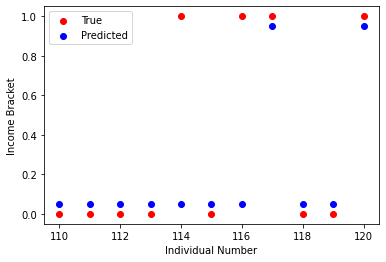

Individual 114:  [48 'Doctorate' 'Prof-specialty' 'Female']
Individual 117:  [41 'Masters' 'Prof-specialty' 'Male']


In [ ]:
plt.scatter(range(110,121), Y_test[range(110,121)], color='red', label="True")
plt.scatter(range(110,121), 0.9*Y_test_hat[range(110,121)] + 0.05, color='blue',
            label="Predicted")
plt.xlabel("Individual Number")
plt.ylabel("Income Bracket")
plt.ylim([-0.05, 1.05])
plt.legend(loc='upper left')
plt.show()

print("Individual 114: ", test_df.values[114,[0,3,6,9]])
print("Individual 117: ", test_df.values[117,[0,3,6,9]])

### Counterfactual Experiment

Consider the hypothetical situation where the genders of Individuals 114 and 117 are fliped. This experiment reveals that

> the classifier seems to be biased against women.

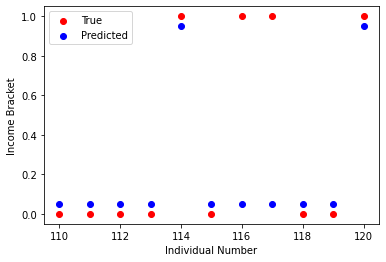

Y_ctf_hat[114] = 1 : Individual 114 would get the loan if she were a male!
Y_ctf_hat[117] = 0 : Individual 117 would not get the loan if he were a female!


In [ ]:
X_ctf = copy.deepcopy(X_test)
X_ctf[114,15] = 0
X_ctf[117,15] = 1

Y_ctf_hat = regressor.predict(X_ctf[:,sel_var])
Y_ctf_hat = 0.5*(1+np.sign(Y_ctf_hat-0.5))

plt.scatter(range(110,121), Y_test[range(110,121)], color='red', label="True")
plt.scatter(range(110,121), 0.9*Y_ctf_hat[range(110,121)] + 0.05, color='blue',
            label="Predicted")
plt.xlabel("Individual Number")
plt.ylabel("Income Bracket")
plt.ylim([-0.05, 1.05])
plt.legend(loc='upper left')
plt.show()

print(r"Y_ctf_hat[114] = %1.0f" % Y_ctf_hat[114],
      ": Individual 114 would get the loan if she were a male!")
print(r"Y_ctf_hat[117] = %1.0f" % Y_ctf_hat[117],
      ": Individual 117 would not get the loan if he were a female!")

### Coefficients Inspection

Recall that $x_{\text{gender}} = 1$ whenever the individual is female and
$$ g_{b,w}(x) = b + w_{1}x_{1} + \cdots + w_{d}x_{d}, \\ h_{b,w}(x) = \begin{cases}1 & g_{b,w}(x) \geq 1/2,\\0 & g_{b,w}(x) < 1/2.\end{cases}$$

<br>

By inspecting the coefficients of the linear regression model, we observe that

$$ \hat{w}_{\text{gender}} = -0.195.$$

Since $x_{\text{gender}} = 1$ whenever an individual is female, the last equation reveals that

> the classifier is heavily biased against women.

In [ ]:
print("Estimated Parameters")
print("b =", regressor.intercept_)
print("w =", regressor.coef_)

Estimated Parameters
b = -0.09763389815894061
w = [ 0.4636149   0.34492326 -0.10517669 -0.00937811  0.21446648 -0.11698065
 -0.0999603  -0.03915323 -0.06505855 -0.02206587  0.18783291  0.07052082
  0.0685273   0.09123771 -0.0274078  -0.19483919]


### Fairness-Aware Classification

A straightforward way to fix this fairness problem is to <font color="blue"><i>restrain our classifier from using gender</i></font>.

In [ ]:
sel_var = range(0,15)

regressor = LinearRegression()
regressor.fit(X_train[:,sel_var],Y_train)

Y_test_hat = regressor.predict(X_test[:,sel_var])
Y_test_hat = 0.5*(1+np.sign(Y_test_hat-0.5))

As shown in the next plot, this fairness-aware classifier

> approves the loan of Individual 114, but not the one of Individual 117.

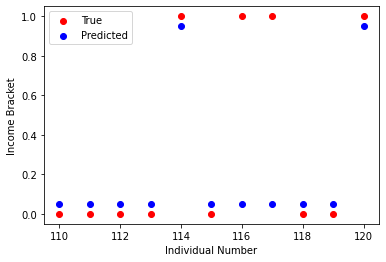

In [ ]:
plt.scatter(range(110,121), Y_test[range(110,121)], color='red', label="True")
plt.scatter(range(110,121), 0.9*Y_test_hat[range(110,121)] + 0.05, color='blue',
            label="Predicted")
plt.xlabel("Individual Number")
plt.ylabel("Income Bracket")
plt.legend(loc='upper left')
plt.show()

### Cost of Fairness

<font color="blue"><i>Fairness typically has a cost</i></font> in terms of performance:

> The fairness-aware classifier exhibits a 1.9% performance loss.

In [ ]:
acc = 100 - 100.0*np.linalg.norm(Y_test_hat-Y_test,1)/15060.0
print("Accuracy = %2.1f%%" % acc)

Accuracy = 77.2%


<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>


### Questions

<font color="blue"><b>Restrain the Use of a Sensitive Attribute</b></font>

In general, is it enough to delete an attribute in order to avoid its use?

–

Not really! Indeed, in the Adult Dataset the attributes <i>Relationship</i> and <i>Gender</i> are highly correlated.

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<font color="blue"><b>Partial Use of a Sensitive Attribute</b></font>

Is it possible to partially use a sensitive attribute?

–

Yes! Think about the following transformation:

> For $p\in[0,1/2]$, let
> $$ x_{\text{gender}}' = \begin{cases}x_{\text{gender}} & \text{with probability }1-p,\\1-x_{\text{gender}} & \text{with probability }p.\end{cases} $$

Extreme cases:
* $p=0$ : use gender as is;
* $p=1/2$ : assign gender at random (independently).

<br>

<b>Moral:</b> $p$ is knob to control how much of the gender we are using.

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<font color="blue"><b>Another Story for Another Time: Additive Noise Mechanism</b></font>

Recall that the XOR operation (modulo 2 addition) is defined by

$$ a \oplus b = \begin{cases}0 & \text{if } a = b,\\ 1 & \text{if }a \neq b.\end{cases}$$

<br>

The previous technique could be expressed as

> $$ x'_{\text{gender}} = x_{\text{gender}} \oplus Z_{p},$$

where $Z_{p} \sim \text{Bern}(p)$ random variable, i.e., $Z_{p}$ is equal to 1 with probability $p$ and 0 with probability $1-p$.

<br>

<b><i><u>"Noise addition might be useful to control the correlation between random variables."</u></i></b>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>


## Conclusion

* A fundamental problem in Fair/Private Machine Learning is
> <font color="blue"><i>to asses and destroy correlation between different (random) variables.</i></font>

* Correlation is quantified using information leakage measures, e.g.,
> <font color="blue"><i>mutual information, total variation, MMSE, Wasserstein distance.</i></font>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

Mario Diaz, IIMAS-UNAM<br>
mario.diaz@sigma.iimas.unam.mx<br>
https://mariodiaztorres.com/